In [1]:
%cd ..

c:\Users\aaron\Documents\Topología aplicada y análisis topológico de datos\DataTopology-2025


c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Setup

In [2]:
import numpy as np
import gudhi
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from src.utils import Filtration_plano_proyectivo, plot_triangles, plot_persistence
from src.algoritmo_persistencia_3oct import build_boundary_matrix, reduce_matrix, extract_barcodes


### Ejercicio 1
Generamos una matriz de distancias aleatoria y simétrica para 5 puntos.

In [3]:
np.random.seed(28)
D = np.random.randint(1, 4, size=(5, 5))
for i in range(5):
    for j in range(i, 5):
        if i == j:
            D[i, j] = 0
        else:
            d = max(D[i, j], D[j, i])
            D[i, j] = d
            D[j, i] = d
print(f'D =\n{D}')

D =
[[0 2 2 3 2]
 [2 0 1 1 1]
 [2 1 0 3 3]
 [3 1 3 0 3]
 [2 1 3 3 0]]


Observamos la filtracion de Vietoris-Rips a partir de `D`, donde $D[i, j] = d(v_i, v_j)$.

Sea $K_i$ el complejo en el paso `i` con $i = 0, 1, 2, 3$. Basta mostrar sus simplices maximales.
- $K_0: \{\{v_5\}, \{v_1\}, \{v_2\}, \{v_3\}, \{v_4\}\}$
- $K_1: \{\{v_2, v_3\}, \{v_2, v_4\}, \{v_2, v_5\}\}$
- $K_2: \{\{v_1, v_3\}, \{v_1, v_2, v_3\}, \{v_1, v_2, v_5\}\}$
- $K_3: \{\{v_1, v_2, v_3, v_4, v_5\}\}$

## Ejercicio 2

In [4]:
# 2. Construcción del complejo de Vietoris-Rips con GUDHI
rips_complex = gudhi.RipsComplex(distance_matrix=D, max_edge_length=3.0)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

# 3. Cálculo de la homología persistente
persistence=simplex_tree.persistence()
persistence

[(0, (0.0, inf)),
 (0, (0.0, 2.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0)),
 (0, (0.0, 1.0))]

c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\gudhi\persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


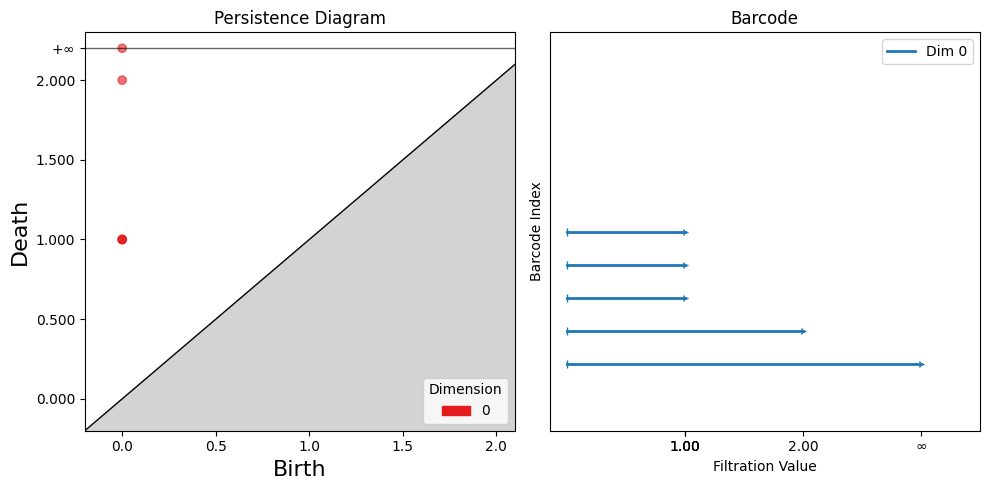

In [5]:
plot_persistence(persistence)

### Ejercicio 3

In [6]:
# Crear el grafo con un ciclo exterior de 6 nodos y un ciclo interior de 3 nodos
cicle_ext = nx.cycle_graph(6)
cicle_int = nx.cycle_graph(3)
cicle_int = nx.relabel_nodes(cicle_int, {i:i+cicle_ext.number_of_nodes() for i in cicle_int.nodes})
G = nx.compose(cicle_ext, cicle_int)

# Aristas adicionales para el plano proyectivo
new_edges = [(0, 7), 
             (1, 7), (1, 8), 
             (2, 8), 
             (3, 6), (3, 8), 
             (4, 6), 
             (5, 6), (5, 7)]
for src, dst in new_edges:
    G.add_edge(src, dst)

VALID_EDGES = list(G.edges())
POSITIONS = nx.spring_layout(G, seed=3)

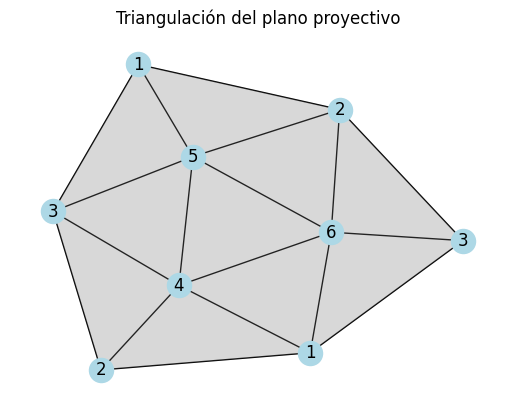

In [7]:
# Plot grafo y fija posiciones
pos = nx.spring_layout(G, seed=3)
fig, ax = plt.subplots()

ids_to_nodes = {
    1: [0, 3],
    2: [1, 4], 
    3: [2, 5],
    4: [6], 5: [7], 6: [8]
}
nodes_to_ids = [1, 2, 3, 1, 2, 3, 4, 5, 6]
labels = {node: f'{id}' for id, nodes in ids_to_nodes.items() for node in nodes}

nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', labels=labels)

# Encontrar todos los triángulos en el grafo
simplex_3s = [list(triangle) for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]
plot_triangles(simplex_3s, ax, pos)

plt.title("Triangulación del plano proyectivo")
plt.show()

#### Filtracion 1

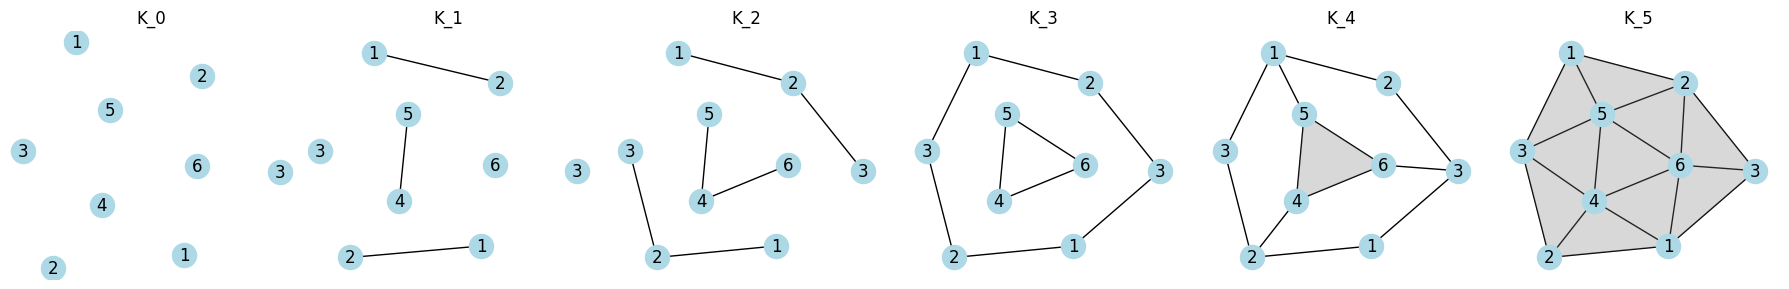

In [8]:
FILTRATION_SIZE = 6  # K0 to K5
SIMPLICES = {
    0: [[1], [2], [3], [4], [5], [6]],
    1: [[1, 2], 
        [4, 5]],
    2: [[2, 3], 
        [4, 6]],
    3: [[1, 3], 
        [5, 6]],
    4: [[1, 5], 
        [2, 4], 
        [3, 6], 
        [5, 4, 6]],
    5: [[1, 4], [1, 6], 
        [2, 5], [2, 6], 
        [3, 4], [3, 5],
        [1, 2, 4], [1, 2, 5], [1, 3, 5], [1, 3, 6], [1, 4, 6],
        [2, 3, 4], [2, 3, 6], [2, 5, 6],
        [3, 4, 5],
        [4, 5, 6]]
    }

st = Filtration_plano_proyectivo(VALID_EDGES, POSITIONS)
for dim in range(FILTRATION_SIZE):
    for simplex in SIMPLICES[dim]:
        st.insert(simplex, filtration=dim)

st.plot(filtration_size=FILTRATION_SIZE)

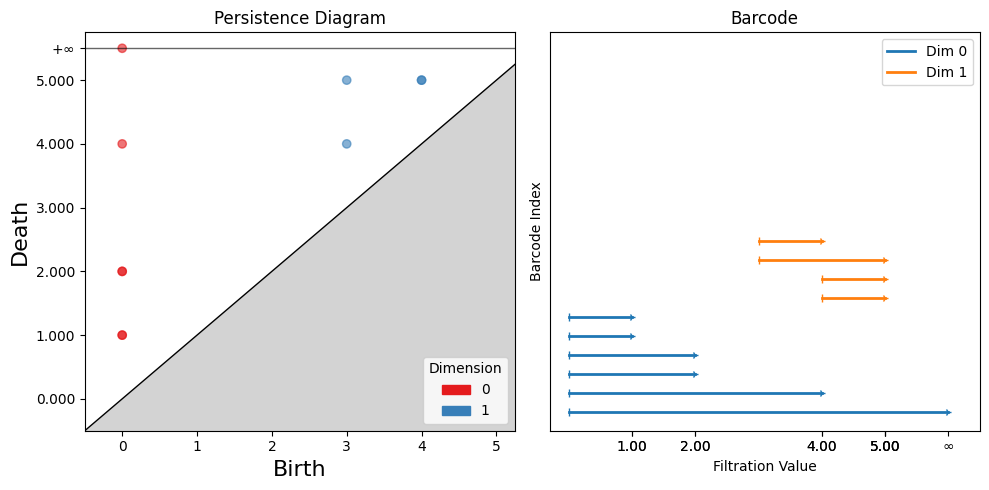

In [9]:
D, simplices = build_boundary_matrix(st)
Dred = reduce_matrix(D)

persistence_Q = st.persistence(Dred, simplices)
plot_persistence(persistence_Q)

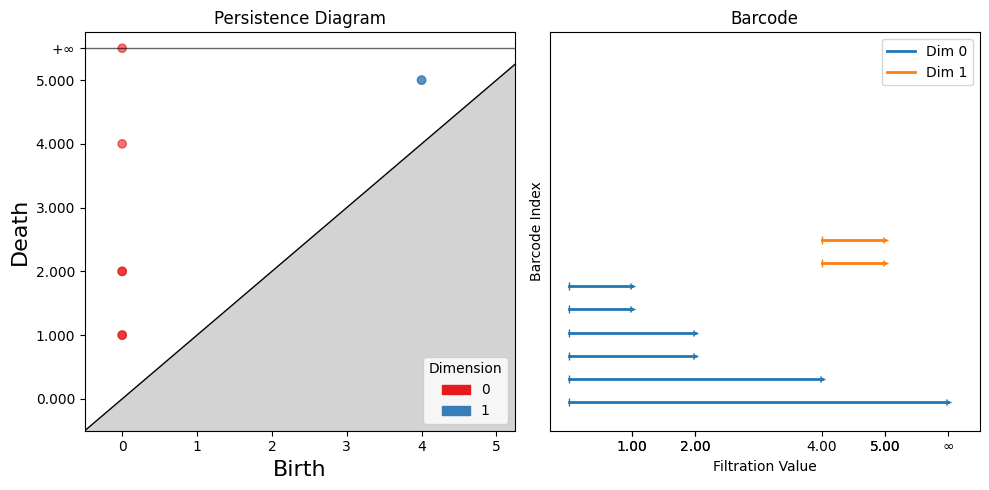

In [10]:
Dist = st.distance_matriz()

# 2. Construcción del complejo de Vietoris-Rips con GUDHI 
rips_complex = gudhi.RipsComplex(distance_matrix=Dist, max_edge_length=5.0)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

# 3. Cálculo de la homología persistente en F_2
persistence=simplex_tree.persistence(homology_coeff_field=2)
plot_persistence(persistence)